In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Flatten, BatchNormalization, Conv1D, MaxPool1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
cc = pd.read_csv("creditcard.csv",sep = ',')
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
#The number and percentage of fraud transactions in the dataset

neg, pos = np.bincount(cc['Class'])
total = neg + pos
print('Total: {}\n Fraud: {} ({:.3f}% of total)\n'.format(total, pos, 100*pos / total))

Total: 284807
 Fraud: 492 (0.173% of total)



Text(0, 0.5, 'Frequency')

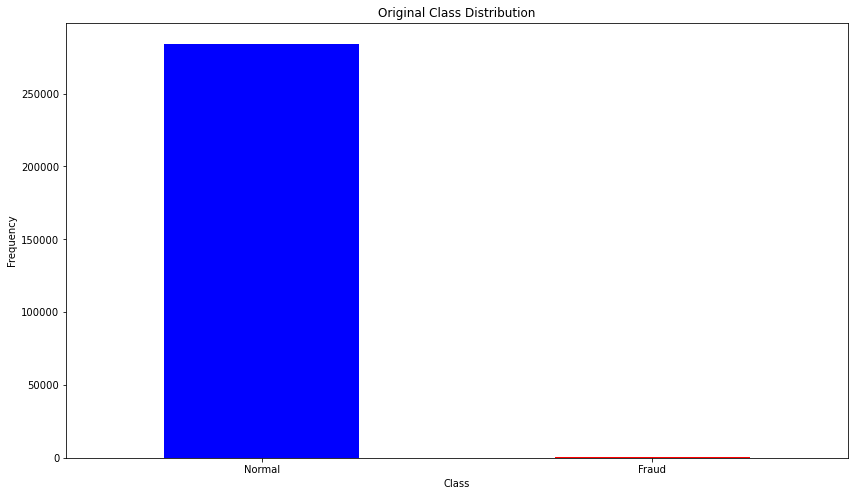

In [5]:
# A bar graph representing the normal and fraud transactions in the dataset

LABELS = ["Normal", "Fraud"]
rcParams['figure.figsize'] = 14,8
count_classes = cc.value_counts(cc['Class'], sort = True)
count_classes.plot(kind = 'bar',  color = ['blue', 'red'], rot = 0)
plt.title("Original Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
#General Descriptive Statistics

cc.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
cc.mean()

Time      9.481386e+04
V1        3.919560e-15
V2        5.688174e-16
V3       -8.769071e-15
V4        2.782312e-15
V5       -1.552563e-15
V6        2.010663e-15
V7       -1.694249e-15
V8       -1.927028e-16
V9       -3.137024e-15
V10       1.768627e-15
V11       9.170318e-16
V12      -1.810658e-15
V13       1.693438e-15
V14       1.479045e-15
V15       3.482336e-15
V16       1.392007e-15
V17      -7.528491e-16
V18       4.328772e-16
V19       9.049732e-16
V20       5.085503e-16
V21       1.537294e-16
V22       7.959909e-16
V23       5.367590e-16
V24       4.458112e-15
V25       1.453003e-15
V26       1.699104e-15
V27      -3.660161e-16
V28      -1.206049e-16
Amount    8.834962e+01
Class     1.727486e-03
dtype: float64

In [8]:
cc.mode()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,163152.0,1.245674,-0.326668,-2.752041,-0.842316,-0.562777,-1.011073,-0.432126,-0.160211,0.170362,...,-0.262581,-0.816264,0.020675,0.357827,0.186423,-0.398828,-0.035866,-0.060282,1.0,0.0
1,NaN,2.055797,0.166975,0.488306,0.635322,2.463072,3.173856,0.014953,0.727706,0.608606,...,0.269765,0.844627,0.140304,0.726212,0.366624,0.096544,0.027735,0.018495,NaN,NaN


In [9]:
cc.median()

Time      84692.000000
V1            0.018109
V2            0.065486
V3            0.179846
V4           -0.019847
V5           -0.054336
V6           -0.274187
V7            0.040103
V8            0.022358
V9           -0.051429
V10          -0.092917
V11          -0.032757
V12           0.140033
V13          -0.013568
V14           0.050601
V15           0.048072
V16           0.066413
V17          -0.065676
V18          -0.003636
V19           0.003735
V20          -0.062481
V21          -0.029450
V22           0.006782
V23          -0.011193
V24           0.040976
V25           0.016594
V26          -0.052139
V27           0.001342
V28           0.011244
Amount       22.000000
Class         0.000000
dtype: float64

In [10]:
#Standardising the dataset

cc['Time'] = StandardScaler().fit_transform(cc['Time'].values.reshape(-1,1))
cc['Amount'] = StandardScaler().fit_transform(cc['Amount'].values.reshape(-1,1))

In [11]:
#Dividing the dataset into independent instnances(from Time-Amount) and dependent instances(Class)

X = cc.drop(['Class'], axis =1)
y = cc['Class']

In [12]:
#Splitting the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape

(199364, 30)

In [13]:
#Balancing the train dataset

from mahakil import *
mahak = MAHAKIL()
x_re, y_re = mahak.fit_sample(X_train,y_train)

173.0


In [14]:
x_re.shape, y_re.shape

((375665, 30), (375665,))

In [15]:
#comparing the 'Class' of the original dataset and the 'Class' of the resampled dataset

from collections import Counter
print('Train dataset shape{}'.format(Counter(y_train)))
print('Resampled Train dataset shape{}'.format(Counter(y_re)))

Train dataset shapeCounter({0: 199019, 1: 345})
Resampled Train dataset shapeCounter({0: 199019, 1: 176646})


In [16]:
from collections import Counter
print('Train dataset shape{}'.format(Counter(y_test)))

Train dataset shapeCounter({0: 85296, 1: 147})


Text(0, 0.5, 'Frequency')

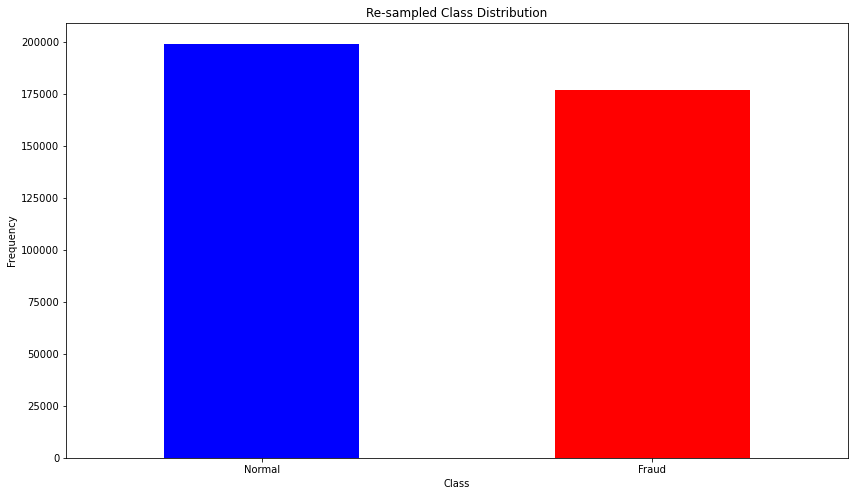

In [17]:
# A bar graph representing the new balanced train dataset

count_classes = pd.value_counts(y_re, sort = True)
count_classes.plot(kind = 'bar', color = ['blue', 'red'], rot = 0)
plt.title("Re-sampled Class Distribution")
plt.xticks(range(2), LABELS,)

plt.xlabel("Class")
plt.ylabel("Frequency")

In [18]:
auto_train = X_train.values
X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=float)

In [19]:
#Reshaping the train and test dataset to meet the requirements of the CNN and LSTM model

Xtrain = x_re.reshape(x_re.shape[0], x_re.shape[1], 1)


In [20]:
Xtest =  X_test.reshape( X_test.shape[0],  X_test.shape[1], 1)


In [21]:
Xtest.shape

(85443, 30, 1)

In [22]:
#The CNN Model

epochs = 10
model1 = Sequential()
model1.add(Conv1D(32, 2, activation='relu', input_shape = Xtrain[0].shape))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv1D(64, 2, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(1, activation='sigmoid'))

In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0

In [24]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
#Training the CNN model with the validation data being X_test and y_test

history = model1.fit(Xtrain, y_re, epochs=10, validation_data=(Xtest, y_test), verbose=1)

Epoch 1/10
11740/11740 [==============================] - 165s 14ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0113 - val_accuracy: 0.9975
Epoch 2/10
11740/11740 [==============================] - 153s 13ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0103 - val_accuracy: 0.9987
Epoch 3/10
11740/11740 [==============================] - 151s 13ms/step - loss: 0.0137 - accuracy: 0.9963 - val_loss: 0.0106 - val_accuracy: 0.9986
Epoch 4/10
11740/11740 [==============================] - 152s 13ms/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 5/10
11740/11740 [==============================] - 148s 13ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0074 - val_accuracy: 0.9990
Epoch 6/10
11740/11740 [==============================] - 150s 13ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0081 - val_accuracy: 0.9989
Epoch 7/10
11740/11740 [==============================] - 150s 13ms/step - loss: 0.0096 - accuracy: 0.9974

In [26]:
y_pred = model1.predict(Xtest)
y_pred = (y_pred>0.5)

In [27]:
#The accuracy of the model

print("Acuracy Score : ", accuracy_score(y_test, y_pred))


Acuracy Score :  0.9986306660580738


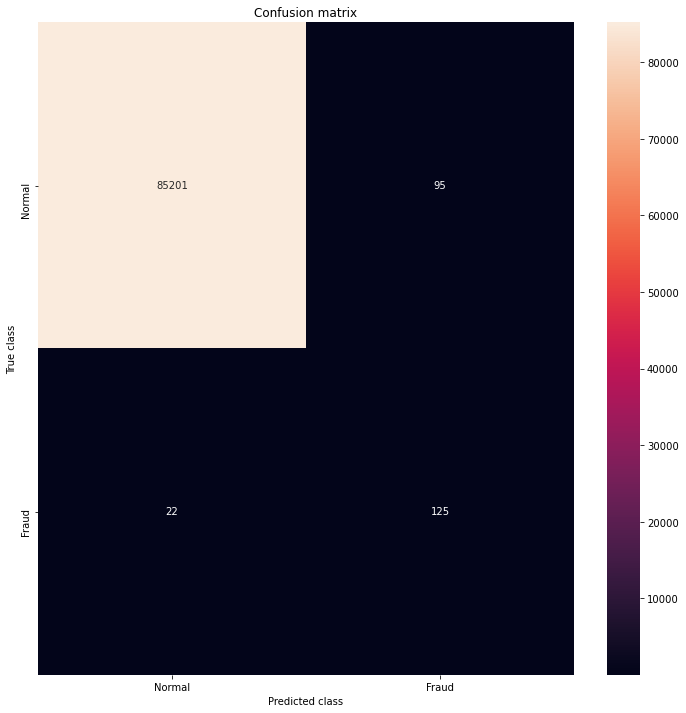

In [28]:
#The confusion matrix of the model

LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, y_pred) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [29]:
print ("")
print ("CNN Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))


CNN Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.57      0.85      0.68       147

    accuracy                           1.00     85443
   macro avg       0.78      0.92      0.84     85443
weighted avg       1.00      1.00      1.00     85443


Accuracy Score:  0.9986306660580738


In [72]:
accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
f1score1 = f1_score(y_test, y_pred) 
print('Accuracy: %f' % accuracy1)
print('Precision: %f' % precision1)
print('F1 score: %f' % f1score1)

Accuracy: 0.998631
Precision: 0.568182
F1 score: 0.681199


In [30]:
#The LSTM model

model2 = Sequential()

model2.add(LSTM(20, input_shape=Xtrain.shape[1:], kernel_initializer='lecun_uniform', activation='relu',
kernel_regularizer=regularizers.l1(0.1), 
recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, 
activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))

model2.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Training the LSTM model with the validation data being X_test and y_test

history = model2.fit(Xtrain, y_re, epochs=10, validation_data=(Xtest, y_test), verbose=1)

Epoch 1/10
11740/11740 [==============================] - 354s 29ms/step - loss: 1.7020 - accuracy: 0.9261 - val_loss: 0.1449 - val_accuracy: 0.9775
Epoch 2/10
11740/11740 [==============================] - 1458s 124ms/step - loss: 0.2137 - accuracy: 0.9397 - val_loss: 0.1080 - val_accuracy: 0.9835
Epoch 3/10
11740/11740 [==============================] - 356s 30ms/step - loss: 0.2113 - accuracy: 0.9382 - val_loss: 0.1371 - val_accuracy: 0.9763
Epoch 4/10
11740/11740 [==============================] - 366s 31ms/step - loss: 0.2074 - accuracy: 0.9386 - val_loss: 0.1260 - val_accuracy: 0.9834
Epoch 5/10
11740/11740 [==============================] - 363s 31ms/step - loss: 0.2056 - accuracy: 0.9392 - val_loss: 0.1037 - val_accuracy: 0.9855
Epoch 6/10
11740/11740 [==============================] - 368s 31ms/step - loss: 0.2017 - accuracy: 0.9408 - val_loss: 0.1045 - val_accuracy: 0.9884
Epoch 7/10
11740/11740 [==============================] - 364s 31ms/step - loss: 0.2013 - accuracy: 0.94

In [33]:
y_pred1 = model2.predict(Xtest)
y_pred1 = (y_pred1>0.5)

In [34]:
#The accuracy of the model


print("Acuracy Score : ", accuracy_score(y_test, y_pred1))


Acuracy Score :  0.985405474995026


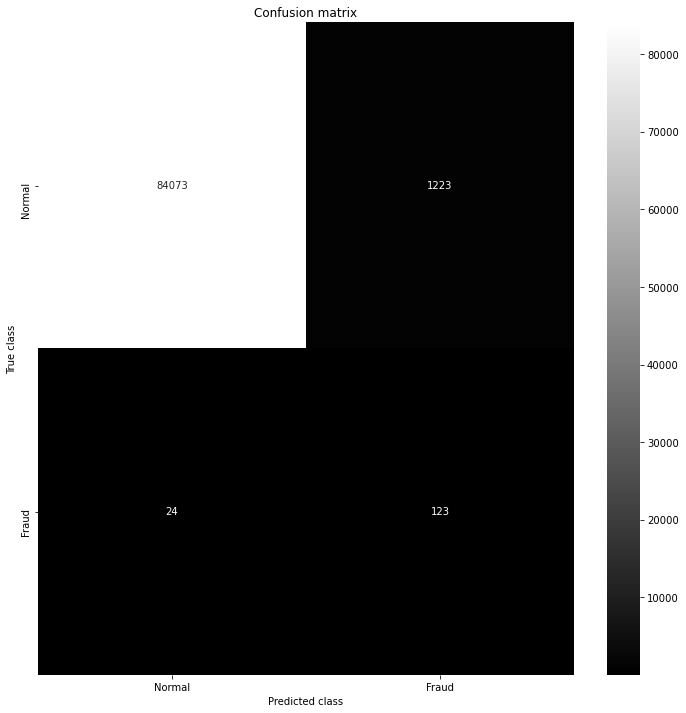

In [81]:
#The confusion matrix of the model

LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, y_pred1) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d",cmap = 'gist_gray'); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [36]:
print ("")
print ("LSTM Report: ")
print (classification_report(y_test, y_pred1))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred1))


LSTM Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     85296
         1.0       0.09      0.84      0.16       147

    accuracy                           0.99     85443
   macro avg       0.55      0.91      0.58     85443
weighted avg       1.00      0.99      0.99     85443


Accuracy Score:  0.985405474995026


In [71]:
accuracy2 = accuracy_score(y_test, y_pred1)
precision2 = precision_score(y_test, y_pred1)
f1score2 = f1_score(y_test, y_pred1) 
print('Accuracy: %f' % accuracy2)
print('Precision: %f' % precision2)
print('F1 score: %f' % f1score2)

Accuracy: 0.985405
Precision: 0.091382
F1 score: 0.164769


In [37]:
nb_epoch = 10
batch_size = 128
input_dim = auto_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [38]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder1_fraud.h5", save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(auto_train, auto_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, 
                          validation_data=(X_test, X_test), verbose=1, callbacks=[cp, tb]).history

Epoch 1/10
1558/1558 [==============================] - 7s 4ms/step - loss: 0.9668 - accuracy: 0.3549 - val_loss: 0.8324 - val_accuracy: 0.5757
Epoch 2/10
1558/1558 [==============================] - 3s 2ms/step - loss: 0.8173 - accuracy: 0.5882 - val_loss: 0.8027 - val_accuracy: 0.6210
Epoch 3/10
1558/1558 [==============================] - 4s 2ms/step - loss: 0.8070 - accuracy: 0.6306 - val_loss: 0.7828 - val_accuracy: 0.6589
Epoch 4/10
1558/1558 [==============================] - 4s 2ms/step - loss: 0.7813 - accuracy: 0.6648 - val_loss: 0.7710 - val_accuracy: 0.6723
Epoch 5/10
1558/1558 [==============================] - 4s 2ms/step - loss: 0.7642 - accuracy: 0.6735 - val_loss: 0.7634 - val_accuracy: 0.6776
Epoch 6/10
1558/1558 [==============================] - 4s 3ms/step - loss: 0.7543 - accuracy: 0.6806 - val_loss: 0.7579 - val_accuracy: 0.6810
Epoch 7/10
1558/1558 [==============================] - 3s 2ms/step - loss: 0.7704 - accuracy: 0.6844 - val_loss: 0.7554 - val_accuracy:

In [39]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

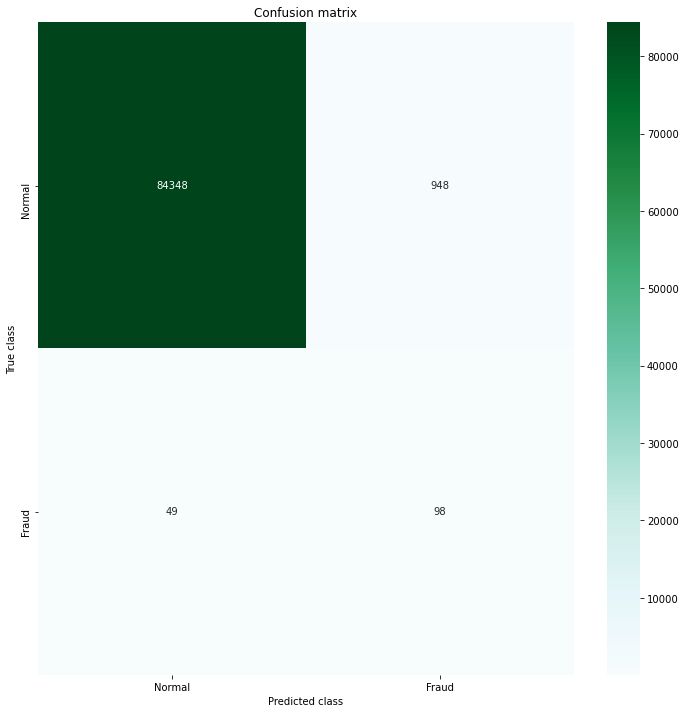

In [96]:
threshold_fixed = 5
LABELS = ["Normal","Fraud"]
y_pred2 = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred2)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap = 'BuGn');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [41]:
print ("Accuracy Score: ", accuracy_score(y_test, y_pred2))

Accuracy Score:  0.988331402221364


In [42]:
print ("")
print ("Auto Encoder Report: ")
print (classification_report(y_test, y_pred2))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred2))


Auto Encoder Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     85296
         1.0       0.09      0.67      0.16       147

    accuracy                           0.99     85443
   macro avg       0.55      0.83      0.58     85443
weighted avg       1.00      0.99      0.99     85443


Accuracy Score:  0.988331402221364


In [70]:
accuracy3 = accuracy_score(y_test, y_pred2)
precision3 = precision_score(y_test, y_pred2)
f1score3 = f1_score(y_test, y_pred2) 
print('Accuracy: %f' % accuracy3)
print('Precision: %f' % precision3)
print('F1 score: %f' % f1score3)

Accuracy: 0.988331
Precision: 0.093690
F1 score: 0.164292
